In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')

sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
# import munkres
# reload(munkres)
from munkres import munkres

# https://github.com/jfrelinger/cython-munkres-wrapper,
# 10 times faster than the python implementation http://software.clapper.org/munkres/

# from munkres import Munkres # http://software.clapper.org/munkres/

In [70]:
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
import utilities2014
reload(utilities2014)
from utilities2014 import *

In [3]:
import os
import time

# os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
# os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
# os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
# os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filter.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline


stack_name = 'RS140'

In [4]:
# Order the exterior by depth-first search
# The ordering is not well-defined in some corners

def find_boundary_sps(clusters, neighbors, neighbor_graph):
    '''
    Identify superpixels that are at the boundary of regions: surround set and frontier set
    
    Parameters
    ----------
    clusters : list of integer lists
    neighbors : neighbor_list
    neighbor_graph : 
    '''
        
    n_superpixels = len(clusters)
    
    surrounds_sps = []
    frontiers_sps = []
    
    for cluster_ind, cluster in enumerate(clusters):
        
        surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
#         surrounds = set([i for i in surrounds if any([(n not in cluster) and (n not in surrounds) for n in neighbors[i]])])
        surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

        if len(surrounds) == 0:
            surrounds_sps.append([])
            frontiers_sps.append([])

        else:
            frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)

            surrounds_subgraph = neighbor_graph.subgraph(surrounds)
            surrounds_traversal = list(dfs_postorder_nodes(surrounds_subgraph))

            frontiers_subgraph = neighbor_graph.subgraph(frontiers)
            frontiers_traversal = list(dfs_postorder_nodes(frontiers_subgraph))

            surrounds_sps.append(surrounds_traversal)
            frontiers_sps.append(frontiers_traversal)
        
    return surrounds_sps, frontiers_sps

In [49]:
def compute_overlap(c1, c2):
    return float(len(c1 & c2)) / min(len(c1),len(c2))

def compute_overlap2(c1, c2):
    return float(len(c1 & c2)) / len(c1 | c2)    

def compute_overlap_partial(indices, sets, metric='jaccard'):
    n_sets = len(sets)
    
    overlap_matrix = np.zeros((len(indices), n_sets))
        
    for ii, i in enumerate(indices):
        for j in range(n_sets):
            c1 = set(sets[i])
            c2 = set(sets[j])
            if len(c1) == 0 or len(c2) == 0:
                overlap_matrix[ii, j] = 0
            else:
                if metric == 'min-jaccard':
                    overlap_matrix[ii, j] = compute_overlap(c1, c2)
                elif metric == 'jaccard':
                    overlap_matrix[ii, j] = compute_overlap2(c1, c2)
            
    return overlap_matrix

def set_pairwise_distances(sets, metric):

    partial_overlap_mat = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(compute_overlap_partial)(s, sets, metric=metric) 
                                        for s in np.array_split(range(len(sets)), 16))
    overlap_matrix = np.vstack(partial_overlap_mat)
    distance_matrix = 1 - overlap_matrix
    
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix



def group_clusters(clusters=None, dist_thresh = 0.1, distance_matrix=None, metric='jaccard',
                  returnD=False, linkage='complete'):

    if distance_matrix is None:
        assert clusters is not None
        distance_matrix = set_pairwise_distances(clusters, metric)
        
    if linkage=='complete':
        lk = complete(squareform(distance_matrix))
    elif linkage=='average':
        lk = average(squareform(distance_matrix))
    elif linkage=='single':
        lk = single(squareform(distance_matrix))

    # T = fcluster(lk, 1.15, criterion='inconsistent')
    T = fcluster(lk, dist_thresh, criterion='distance')
    
    n_groups = len(set(T))
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]

    if returnD:
        return [g for g in groups if len(g) > 0], distance_matrix
    else:
        return [g for g in groups if len(g) > 0]


In [6]:
# def detect_open_boundaries(sec_ind):
    
#     dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec_ind)
    
#     # Load image and relevant data
#     im_height, im_width = imread(dm._get_image_filepath()).shape[:2]

#     texton_hists = dm.load_pipeline_result('texHist', 'npy')
#     segmentation = dm.load_pipeline_result('segmentation', 'npy')
#     n_superpixels = len(np.unique(segmentation)) - 1
#     textonmap = dm.load_pipeline_result('texMap', 'npy')
#     n_texton = len(np.unique(textonmap)) - 1
#     neighbors = dm.load_pipeline_result('neighbors', 'npy')
#     sp_properties = dm.load_pipeline_result('spProps', 'npy')
#     segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

#     # Load region proposals
#     expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
#     expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
#     expansion_cluster_scores = np.array(expansion_cluster_scores)

#     neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
#     neighbor_graph = from_dict_of_lists(neighbors_dict)
        
#     surrounds_sps, frontiers_sps = find_boundary_sps(expansion_clusters, neighbors=neighbors, neighbor_graph=neighbor_graph)
    
    
#     # votes for directed edgelets
#     dEdge_votes = defaultdict(int)
    
#     # Compute the supporter sets of every edgelet, based on region proposals
#     # supporter_all[(100,101)] is the set of superpixels that supports directed edgelet (100,101)
#     supporters_all = defaultdict(list)

#     for s in range(n_superpixels):
#     #     if s not in sps_in_good_regions: continue

#         c = list(expansion_clusters[s])
#         interior_texture = texton_hists[c].mean(axis=0)
#         b_sps = surrounds_sps[s]
#         b_contrasts = cdist(texton_hists[b_sps], interior_texture[np.newaxis, :], chi2)

#         for b_sp, b_contrast in zip(b_sps, b_contrasts):
#             int_sps = neighbors[b_sp] & set(c)
#             for int_sp in int_sps:
#                 dEdge_votes[(b_sp, int_sp)] += b_contrast / max(len(c), 5)
#                 dEdge_votes[(int_sp, b_sp)] += b_contrast / max(len(c), 5)
#                 supporters_all[(b_sp, int_sp)].append(s) # (border_sp, interior_sp) or (out, in)
    
#     edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')
    
#     # threshold the edgelet votes
#     dEdge_vote_thresh = 1.
#     winner_dEdges = [dedge for dedge, v in dEdge_votes.iteritems() if v > dEdge_vote_thresh]
    
#     # group the winning edgelets, according to their supporter sets
#     winner_supporters = [supporters_all[dedge] for dedge in winner_dEdges]
#     supporter_D = set_pairwise_distances(winner_supporters, metric=1)
#     supporter_sim_thresh = .2
#     winner_indices_grouped_by_supporters = group_clusters(winner_supporters, dist_thresh=supporter_sim_thresh, 
#                                                           distance_matrix=supporter_D)
# #     print len(winner_indices_grouped_by_supporters), 'alliances'
#     winners_grouped_by_supporters = [[winner_dEdges[i] for i in g] for g in winner_indices_grouped_by_supporters]
    
#     alliance_sizes = np.array(map(len, winners_grouped_by_supporters))

#     # pick edgelet groups with more than 20 edgelets
#     big_alliance_indices = np.where(alliance_sizes > 20)[0]
# #     print len(big_alliance_indices), 'big alliances'
#     big_alliance_dEdges = [winners_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
#     big_alliance_winnerIndices = [winner_indices_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
#     big_alliance_supporters = [set.union(*[set(winner_supporters[i]) for i in a]) for a in big_alliance_winnerIndices]
#     # define supporter set of an edgelet group as the union of each supporter set

#     # sort edgelet groups by total vote over all edgelets
#     good_edgeSet_tuple_sorted_by_score = sorted([(np.sum([dEdge_votes[e] for e in edges]), edges, alliance_ind)
#                                                       for alliance_ind, edges in enumerate(big_alliance_dEdges)
#                                                       if len(edges) > 10], reverse=True)
#     good_edgeSet_scores_sorted, good_edgeSets_sorted, good_edgeSet_indices_sorted = zip(*good_edgeSet_tuple_sorted_by_score)  
#     good_edgeSet_supporters = [ big_alliance_supporters[alliance_i] for alliance_i in good_edgeSet_indices_sorted]
#     # give this to Idan's web interface
    
# #     print len(good_edgeSet_tuple_sorted_by_score), 'good boundaries'
    
#     # These edgelet groups constitute Open Boundary landmarks.
    
#     vis = dm.visualize_edge_sets(good_edgeSets_sorted[:10])
#     dm.save_pipeline_result(vis, 'openBoundariesTop10', 'jpg')
    
#     dm.save_pipeline_result(good_edgeSet_tuple_sorted_by_score, 'openBoundaries', 'pkl')
#     dm.save_pipeline_result(good_edgeSet_supporters, 'openBoundariesSupporters', 'pkl')

In [7]:
def combine_two_landmark_types(sec_ind):
    
    dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec_ind)
    texton_hists = dm.load_pipeline_result('texHist', 'npy')
    edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')
    
    # Load closed region landmarks
    representative_clusters = dm.load_pipeline_result('representativeClusters', 'pkl')

    representative_cluster_scores_sorted, representative_clusters_sorted_by_score, \
    representative_cluster_indices_sorted_by_score, big_groups_sorted_by_score = zip(*representative_clusters)

    closedRegion_edgeSets_sorted_by_score = dm.load_pipeline_result('closedRegionsTop30Edgesets', 'pkl')

    # Load open boundary landmarks
    openBoundaries = dm.load_pipeline_result('openBoundaries', 'pkl')
    
    openBoundaries_scores_sorted, openBoundaries_edgeSets_sorted_by_score, \
    openBoundaries_indices_sorted_by_score = zip(*openBoundaries)
    
    openBoundaries_supporters = dm.load_pipeline_result('openBoundariesSupporters', 'pkl')

    
    # Select top 30 Closed Boundary landmarks and top 10 Open Boundary landmarks
    all_edgeSets = list(chain(*[closedRegion_edgeSets_sorted_by_score, 
                                openBoundaries_edgeSets_sorted_by_score[:10]]))
    all_scores = list(chain(*[representative_cluster_scores_sorted, 
                                openBoundaries_scores_sorted[:10]]))

    lm_types = np.r_[np.zeros((len(closedRegion_edgeSets_sorted_by_score),)), 
                    np.ones((10,))]
    
    # Represent each landmark with a tuple
    # (edgeSet, interior_texture, exterior_textures, points, center, supporter_set(?))
    boundary_models = []

    all_supporters = list(representative_clusters_sorted_by_score[:30]) + list(openBoundaries_supporters[:10])
    #     dm.save_pipeline_result(lm_supporters, 'supporters', 'pkl')

#     overlapping_boundary_groups, D = group_clusters(all_supporters, dist_thresh = 0.1, metric=2,
#                                                 returnD=True)
    overlapping_boundary_groups, D = group_clusters(all_edgeSets, dist_thresh = 0.6, metric=1,
                                                returnD=True)
    
    # select the landmark with the largest supporter set to represent each group (may need a better idea)
    # using score is meaningless if comparison is between different types.
    nonoverlapping_lm_indices = [c[np.argmax([len(all_supporters[i]) for i in c])] for c in overlapping_boundary_groups]
#     print overlapping_boundary_groups
#     print nonoverlapping_lm_indices

    nonoverlapping_scores = [all_scores[i] for i in nonoverlapping_lm_indices]
    
    nonoverlapping_edgeSets = [all_edgeSets[i] for i in nonoverlapping_lm_indices]    
    nonoverlapping_lm_supporters = [all_supporters[i] for i in nonoverlapping_lm_indices]
    nonoverlapping_lm_types = [lm_types[i] for i in nonoverlapping_lm_indices]
    
    order = np.argsort(nonoverlapping_scores)[::-1]
    
    nonoverlapping_edgeSets_sorted_by_score = [nonoverlapping_edgeSets[i] for i in order]
    nonoverlapping_lm_supporters_sorted_by_score = [nonoverlapping_lm_supporters[i] for i in order]
    nonoverlapping_lm_types_sorted_by_score = [nonoverlapping_lm_types[i] for i in order]

    #     dm.save_pipeline_result(nonoverlapping_lm_supporters, 'nonoverlappingSupporters', 'pkl')

    #     for edgeSet_ind, edgeSet in zip(good_edgeSet_indices_sorted, good_edgeSets_sorted):

    interior_superpixels = []
    for edgeSet, spptrs, lm_type in zip(nonoverlapping_edgeSets_sorted_by_score, 
                                        nonoverlapping_lm_supporters_sorted_by_score, 
                                        nonoverlapping_lm_types_sorted_by_score):

        # interior_texture = texton_hists[list(big_alliance_supporters[edgeSet_ind])].mean(axis=0)

        surrounds = [e[0] for e in edgeSet]
        frontiers = [e[1] for e in edgeSet]

        if lm_type == 1: # OpenBoundaries
            interior_texture = texton_hists[frontiers].mean(axis=0)
            interior_superpixels.append(list(set(frontiers)))
        else: # CloseRegions
            interior_texture = texton_hists[list(spptrs)].mean(axis=0)
            interior_superpixels.append(list(set(spptrs)))
            
        exterior_textures = np.array([texton_hists[s] if s!=-1 else np.nan * np.ones((texton_hists.shape[1],)) for s in surrounds])
        # how to deal with -1 in surrounds? Assign to an all np.nan vector
        
        points = np.array([edge_coords[frozenset(e)].mean(axis=0) for e in edgeSet])

        center = points.mean(axis=0)

        boundary_models.append((edgeSet, interior_texture, exterior_textures, points, center))
        
    dm.save_pipeline_result(boundary_models, 'boundaryModels', 'pkl')
    dm.save_pipeline_result(nonoverlapping_lm_types_sorted_by_score, 'nonoverlapLmTypes', 'npy')
    dm.save_pipeline_result(interior_superpixels, 'internalSps', 'pkl')
    
#     return all_edgeSets, D
    

In [8]:
def generate_boundary_visualizations(sec):
    '''
    Generate visualization for boundaries of sec. 
    '''
    
    dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec)
    
    boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')

    # Save output
    for i, b in enumerate(boundaries):
        dm.save_pipeline_result(dm.visualize_edges(b[0], text=False, color=[0,255,0]), 'boundary%02d'%i, 'jpg')
    
    vis = dm.visualize_edge_sets([b[0] for b in boundaries], text=False)
    dm.save_pipeline_result(vis, 'allBoundaries', 'jpg')
    
    vis = dm.visualize_edge_sets([b[0] for b in boundaries], text=True)
    dm.save_pipeline_result(vis, 'allBoundariesWithLabel', 'jpg')
    

In [9]:
from subprocess import check_output
s = check_output("ssh gordon.sdsc.edu ls %s" % os.path.join(os.environ['GORDON_DATA_DIR'], stack_name, 'x5'), shell=True)
slide_indices = [int(f) for f in s.split('\n') if len(f) > 0]

In [10]:
# def detect_open_boundaries(sec_ind):
    
dm = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=7)

# Load image and relevant data
im_height, im_width = imread(dm._get_image_filepath()).shape[:2]

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
neighbors = dm.load_pipeline_result('neighbors', 'pkl')
sp_properties = dm.load_pipeline_result('spProps', 'npy')
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

# Load region proposals
expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
expansion_cluster_scores = np.array(expansion_cluster_scores)

neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
neighbor_graph = from_dict_of_lists(neighbors_dict)

surrounds_sps, frontiers_sps = find_boundary_sps(expansion_clusters, neighbors=neighbors, neighbor_graph=neighbor_graph)


######################
group_size_thresh = 5
######################


# votes for directed edgelets
dEdge_votes = defaultdict(float)

# Compute the supporter sets of every edgelet, based on region proposals
# supporter_all[(100,101)] is the set of superpixels that supports directed edgelet (100,101)
supporters_all = defaultdict(list)

for s in range(n_superpixels):
#     if s not in sps_in_good_regions: continue

    c = list(expansion_clusters[s])
    interior_texture = texton_hists[c].mean(axis=0)
    b_sps = surrounds_sps[s]
    b_contrasts = cdist(texton_hists[b_sps], interior_texture[np.newaxis, :], chi2)

    for b_sp, b_contrast in zip(b_sps, b_contrasts):
        int_sps = neighbors[b_sp] & set(expansion_clusters[s])
        for int_sp in int_sps:
            # weight of each edgelet is the contrast normalized by region size
            weight = float(b_contrast) / max(len(c), 5)
            dEdge_votes[(b_sp, int_sp)] += weight
            dEdge_votes[(int_sp, b_sp)] += weight
            supporters_all[(b_sp, int_sp)].append(s) # (border_sp, interior_sp) or (out, in)

# edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')

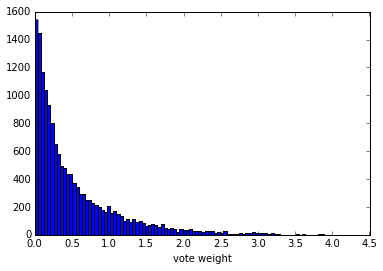

In [11]:
plt.hist(dEdge_votes.values(), bins=100);
plt.xlabel('vote weight');

In [36]:
dEdge_vote_thresh = .5

In [12]:
dm._load_image()

In [14]:
edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')

In [16]:
img_edge = np.zeros_like(dm.image_rgb, np.float)
img_edge_alpha = np.zeros_like(dm.image, np.float)
for edge, s in dEdge_votes.iteritems():
        cs = np.array(list(edge_coords[frozenset(edge)]))
        img_edge[cs[:,0], cs[:,1]] = (1.,0,0)
        img_edge_alpha[cs[:,0], cs[:,1]] = s
    
# img_n = (img-img.min())/(img.max()-img.min())
img_edge_alpha = (img_edge_alpha-img_edge_alpha.min())/(img_edge_alpha.max()-img_edge_alpha.min())
# img_edge = plt.cm.Reds(img_n)
# img_edge_alpha = .8 * np.ones_like(img)
# img_edge_alpha[img_n == 0] = 0
display(img_edge_alpha)

img_vote = alpha_blending(img_as_float(gray2rgb(dm.image)), img_edge, 
                          .2 * np.ones_like(dm.image), .8 * img_edge_alpha)
img_vote[~dm.mask] = 0.
display(img_vote)

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [37]:
img_edge = np.zeros_like(dm.image_rgb, np.float)
img_edge_alpha = np.zeros_like(dm.image, np.float)
for edge, s in dEdge_votes.iteritems():
    if s > dEdge_vote_thresh:
        cs = np.array(list(edge_coords[frozenset(edge)]))
        img_edge[cs[:,0], cs[:,1]] = (1.,0,0)
        img_edge_alpha[cs[:,0], cs[:,1]] = s
    
img_edge_alpha = (img_edge_alpha-img_edge_alpha.min())/(img_edge_alpha.max()-img_edge_alpha.min())
display(img_edge_alpha)

img_highvote = alpha_blending(img_as_float(gray2rgb(dm.image)), img_edge, 
                          .2 * np.ones_like(dm.image), .8 * img_edge_alpha)
img_highvote[~dm.mask] = 0.
display(img_highvote)

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [149]:
cluster_dist_mat = set_pairwise_distances(expansion_clusters, metric=2)

In [151]:
sp_groups_by_expansion_regions = group_clusters(dist_thresh=.8, distance_matrix=cluster_dist_mat)

In [38]:
good_edges = [dedge for dedge, v in dEdge_votes.iteritems() if v > dEdge_vote_thresh]
good_edge_lens = [len(edge_coords[frozenset(e)]) for e in good_edges]
winner_supporters = [supporters_all[dedge] for dedge in good_edges]

In [ ]:
supporter_dist_mat_jac = set_pairwise_distances(winner_supporters, metric='jaccard')

In [62]:
supporter_dist_mat_minjac = set_pairwise_distances(winner_supporters, metric='min-jaccard')

In [52]:
supporter_sim_thresh = .2

In [63]:
good_edges_grouped_by_supporters = group_clusters(dist_thresh=supporter_sim_thresh, 
                                                  distance_matrix=supporter_dist_mat_minjac,
                                                 linkage='complete')

In [38]:
edges = edge_coords.keys()

In [66]:
edge_map = -1 * np.ones_like(dm.image, np.int)

In [67]:
for ei, (e, pts_set) in enumerate(edge_coords.iteritems()):
    rs, cs = zip(*pts_set)
    edge_map[np.array(rs), np.array(cs)] = ei

In [81]:
edge_coords[edges[0]]

{(1800, 4610),
 (1800, 4611),
 (1800, 4612),
 (1801, 4610),
 (1801, 4611),
 (1801, 4612),
 (1802, 4608),
 (1802, 4609),
 (1802, 4610),
 (1802, 4611),
 (1802, 4612),
 (1803, 4608),
 (1803, 4609),
 (1803, 4610),
 (1803, 4612),
 (1804, 4609),
 (1804, 4610),
 (1805, 4610)}

In [ ]:
def f(edge_coords):
    return [set(zip(*np.dstack([np.mgrid[max(r-5,0):min(r+5, dm.image_height), 
                                         max(c-5,0):min(c+5, dm.image_width)].reshape((2,-1)) 
                                for r,c in pts]).reshape((2,-1)).tolist())) 
            for e, pts in edge_coords]

b = Parallel(n_jobs=16)(delayed(f)(s) for s in np.array_split(edge_coords.items(), 16))

In [151]:
neighborhood_pts = [p for bb in b for p in bb]

In [159]:
edge_neighbors = defaultdict(set)
for ei, e in enumerate(edges):
    pts = neighborhood_pts[ei]
    rs, cs = zip(*pts)
    edge_neighbors[ei] |= set(edge_map[rs,cs])

IndexError: index 5922 is out of bounds for axis 1 with size 5920

In [102]:
display(dm.visualize_edge_sets(dedge_sets_sorted_by_size[:20], img=segmentation_vis, 
                               text=True, directed=True))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [101]:
len(dedge_sets)

151

In [100]:
dedge_sets = [[good_edges[i] for i in g] for g in good_edges_grouped_by_supporters if len(g) > 10]
dedge_set_lens = [sum([len(edge_coords[frozenset(e)]) for e in es]) for es in dedge_sets]
dedge_sets_sorted_by_size = [x for (y,x) in sorted(zip(dedge_set_lens,dedge_sets), reverse=True)]

In [64]:
edge_sets = [[frozenset(good_edges[i]) for i in g] for g in good_edges_grouped_by_supporters if len(g) > 10]
edge_sets_sorted_by_size = sorted(edge_sets, key=len, reverse=True)

In [ ]:
# threshold the edgelet votes
# winner_dEdges = [dedge for dedge, v in dEdge_votes.iteritems() if v > dEdge_vote_thresh]

# group the winning edgelets, according to their supporter sets
# winner_supporters = [supporters_all[dedge] for dedge in winner_dEdges]

winner_supporters = [supporters_all[dedge] for dedge in dEdge_votes.keys()]
supporter_D = set_pairwise_distances(winner_supporters, metric=1)

winner_indices_grouped_by_supporters = group_clusters(clusters=winner_supporters, 
                                                      dist_thresh=supporter_sim_thresh, 
                                                      distance_matrix=supporter_D)
#     print len(winner_indices_grouped_by_supporters), 'alliances'
winners_grouped_by_supporters = [[winner_dEdges[i] for i in g] for g in winner_indices_grouped_by_supporters]

alliance_sizes = np.array(map(len, winners_grouped_by_supporters))

In [24]:
# pick edgelet groups with more than certain # of edgelets
big_alliance_indices = np.where(alliance_sizes > group_size_thresh)[0]

#     print len(big_alliance_indices), 'big alliances'
big_alliance_dEdges = [winners_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
big_alliance_winnerIndices = [winner_indices_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
big_alliance_supporters = [set.union(*[set(winner_supporters[i]) for i in a]) for a in big_alliance_winnerIndices]
# define supporter set of an edgelet group as the union of each supporter set

# sort edgelet groups by total vote of all edgelets
good_edgeSet_tuple_sorted_by_score = sorted([(np.sum([dEdge_votes[e] for e in edges]), edges, alliance_ind)
                                                  for alliance_ind, edges in enumerate(big_alliance_dEdges)
                                                  if len(edges) > 10], reverse=True)
good_edgeSet_scores_sorted, good_edgeSets_sorted, good_edgeSet_indices_sorted = zip(*good_edgeSet_tuple_sorted_by_score)  
good_edgeSet_supporters = [ big_alliance_supporters[alliance_i] for alliance_i in good_edgeSet_indices_sorted]
    # give this to Idan's web interface
    
#     print len(good_edgeSet_tuple_sorted_by_score), 'good boundaries'
    
    # These edgelet groups constitute Open Boundary landmarks.
    
#     vis = dm.visualize_edge_sets(good_edgeSets_sorted[:10])
#     dm.save_pipeline_result(vis, 'openBoundariesTop10', 'jpg')
    
#     dm.save_pipeline_result(good_edgeSet_tuple_sorted_by_score, 'openBoundaries', 'pkl')
#     dm.save_pipeline_result(good_edgeSet_supporters, 'openBoundariesSupporters', 'pkl')

In [10]:
# dm = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=7)
# t = dm.load_pipeline_result('openBoundaries', 'pkl')

In [12]:
# score, edgesets, _ = zip(*t)

In [25]:
display(dm.visualize_edge_sets(good_edgeSets_sorted, text=True))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [16]:
b = time.time()
Parallel(n_jobs=16)(delayed(detect_open_boundaries)(sec_ind) for sec_ind in slide_indices)
a = time.time()
print 'detect_open_boundaries', a - b

saved /home/yuncong/project/DavidData2014results/RS140/0015/RS140_x5_0015_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0013/RS140_x5_0013_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0014/RS140_x5_0014_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0012/RS140_x5_0012_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0010/RS140_x5_0010_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0009/RS140_x5_0009_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0007/RS140_x5_0007_gabor-bl

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops 

In [18]:
b = time.time()
Parallel(n_jobs=16)(delayed(combine_two_landmark_types)(sec_ind) for sec_ind in slide_indices)
a = time.time()
print 'combine_two_landmark_types', a - b

detect_open_boundaries 14.6288380623
saved /home/yuncong/project/DavidData2014results/RS140/0007/RS140_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0006/RS140_x5_0006_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0005/RS140_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0003/RS140_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0001/RS140_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0010/RS140_x5_0010_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0002/RS140_x5_0002_g

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops 

In [ ]:
# # Find boundaries for all sections

# for sec_ind in slide_indices:
    
# # #     b = time.time()
#     detect_open_boundaries(sec_ind)
# # #     print 'detect_open_boundaries', time.time()-b
    
# # #     b = time.time()
#     combine_two_landmark_types(sec_ind)
# # #     print 'combine_two_landmark_types', time.time()-b

In [ ]:
Parallel(n_jobs=16)(delayed(generate_boundary_visualizations)(sec_ind) for sec_ind in slide_indices)